In [1]:
# install packages
!pip install librosa
!pip install pywt
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import pywt

In [3]:
def get_high_pass_filter(cutoff_freq, sr):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff_freq / nyquist
    return scipy.signal.butter(1, normal_cutoff, btype='high', analog=False)

def reduce_noise(y, sr, noise_sample, n_fft=2048, hop_length=512, n_std_thresh=1.5):
    noise_stft = librosa.stft(noise_sample, n_fft=n_fft, hop_length=hop_length)
    noise_stft_db = librosa.amplitude_to_db(np.abs(noise_stft), ref=np.max)
    
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    
    audio_stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    audio_stft_db = librosa.amplitude_to_db(np.abs(audio_stft), ref=np.max)
    
    thresh = mean_freq_noise + n_std_thresh * std_freq_noise
    mask = audio_stft_db > thresh[:, np.newaxis]
    audio_stft_db_masked = np.where(mask, audio_stft_db, thresh[:, np.newaxis])
    
    audio_stft_db_masked_lin = librosa.db_to_amplitude(audio_stft_db_masked)
    
    y_denoised = librosa.istft(audio_stft_db_masked_lin, hop_length=hop_length)
    
    return y_denoised

In [4]:
# target audio file
flight_train_path = '../audios/Barn Owl Nestling\'s Adorable Flight Training Session!.mp3'
y_ft, sr_ft = librosa.load(flight_train_path)

ft_noise_start = 81.5
ft_noise_end = 82.5

ft_noise_sample = y_ft[int(ft_noise_start * sr_ft):int(ft_noise_end * sr_ft)]
y_ft_denoised = reduce_noise(y_ft, sr_ft, ft_noise_sample)

In [5]:
def produce_spectrogram(y, sr, cutoff_freq, method='stft', amplitude_t=-40, dur=20):
    b, a = get_high_pass_filter(cutoff_freq, sr)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    if dur != -1:
        y_filtered = y_filtered[:int(dur * sr)]
    if method == 'stft':
        D_filtered = librosa.stft(y_filtered)
        S_db_filtered = librosa.amplitude_to_db(np.abs(D_filtered), ref=np.max)

        plt.figure(figsize=(12, 8))
        librosa.display.specshow(S_db_filtered, sr=sr, x_axis='time', y_axis='log')

        plt.ylim(512, sr // 2)

        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram (Frequency vs. Time) with High-Pass Filter at 1024Hz')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.clim(vmin=amplitude_t)  # Set the minimum amplitude to display
        plt.show()

        # max amplitude
        frequencies = librosa.fft_frequencies(sr=sr, n_fft=D_filtered.shape[0])
        times = librosa.frames_to_time(np.arange(S_db_filtered.shape[1]), sr=sr, hop_length=512, n_fft=2048)
        peak_frequencies = frequencies[np.argmax(S_db_filtered, axis=0)]

        plt.figure(figsize=(12, 8))
        plt.plot(times, peak_frequencies, label='Peak Frequency')
        plt.ylim(512, sr // 2)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Peak Frequency Over Time for First 20 Seconds')
        plt.legend()
        plt.show()
    if method == 'wavelet':
        scales = np.arange(1, 64)
        
        coef, freq = pywt.cwt(y_filtered, scales, 'morl', sampling_period=1/sr)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(np.abs(coef), extent=[0, dur, scales[-1], scales[0]], cmap='viridis', aspect='auto',
                   vmax=np.abs(coef).max(), vmin=-np.abs(coef).max())
        plt.colorbar(label='Magnitude')
        plt.title('Wavelet Transform (CWT) of the Audio Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Scale')
        plt.yscale('log')
        plt.ylim(scales[-1], scales[0])
        plt.show()
        
        peak_frequencies = freq[np.argmax(np.abs(coef), axis=0)]
        times = np.linspace(0, dur, len(peak_frequencies))

        plt.figure(figsize=(12, 8))
        plt.plot(times, peak_frequencies, label='Peak Frequency')
        plt.ylim(512, 10000)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Peak Frequency Over Time for First 20 Seconds')
        plt.legend()
        plt.show()

In [6]:
def filter_response_plots(y, sr, freq):
    b, a = get_high_pass_filter(freq, sr_ft)
    w, h = scipy.signal.freqz(b, a)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(0.5 * sr * w / np.pi, np.abs(h), 'b')
    plt.title('High-Pass Filter Frequency Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(0.5 * sr * w / np.pi, np.angle(h), 'b')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [radians]')
    plt.grid()

    plt.tight_layout()
    plt.show()

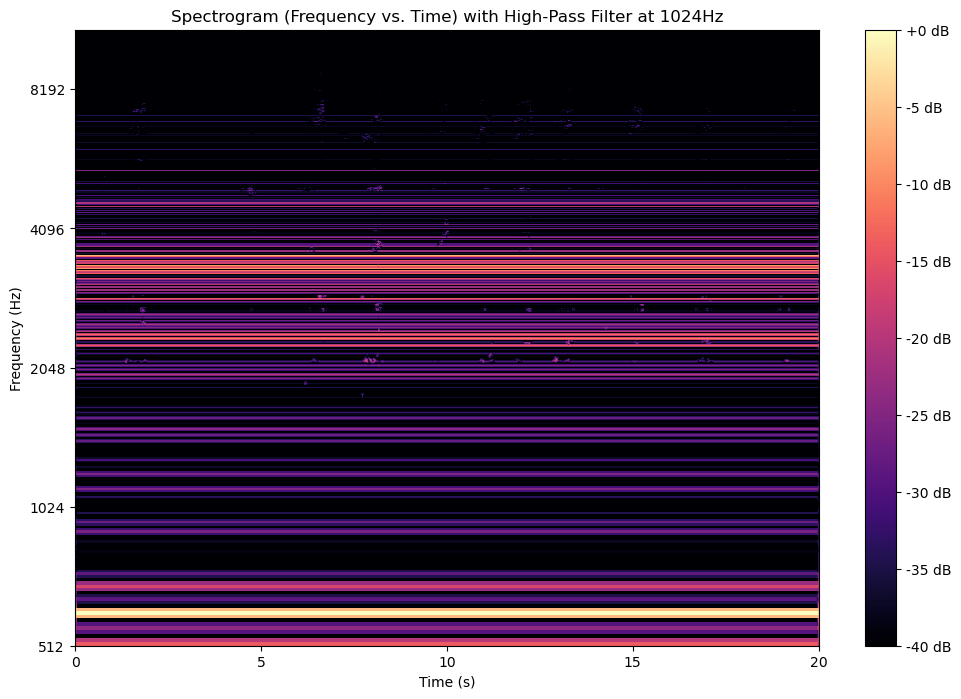

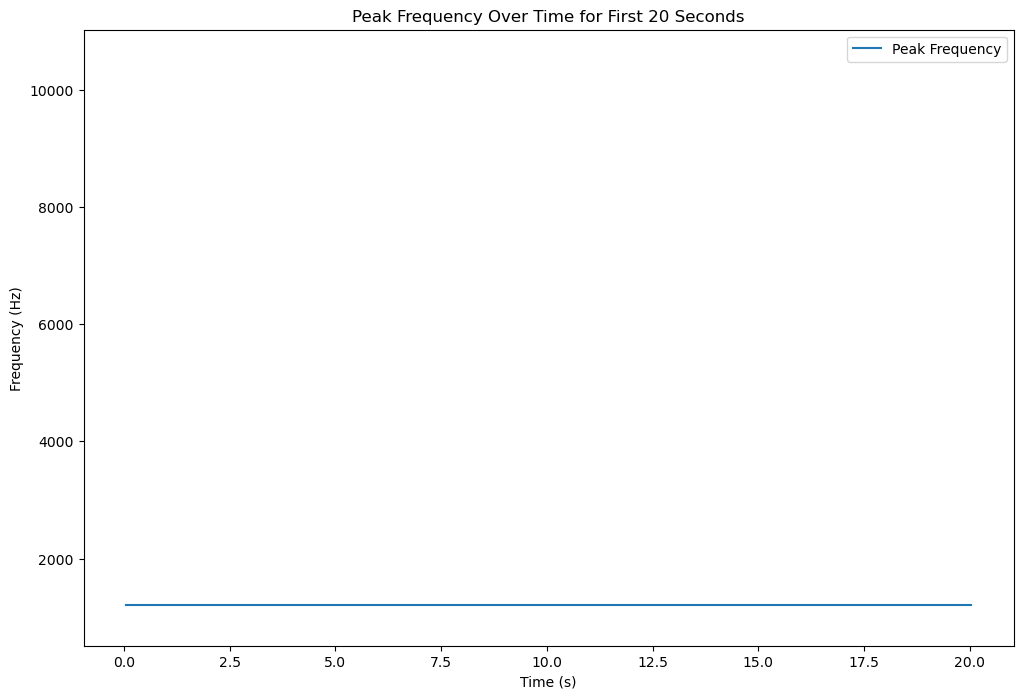

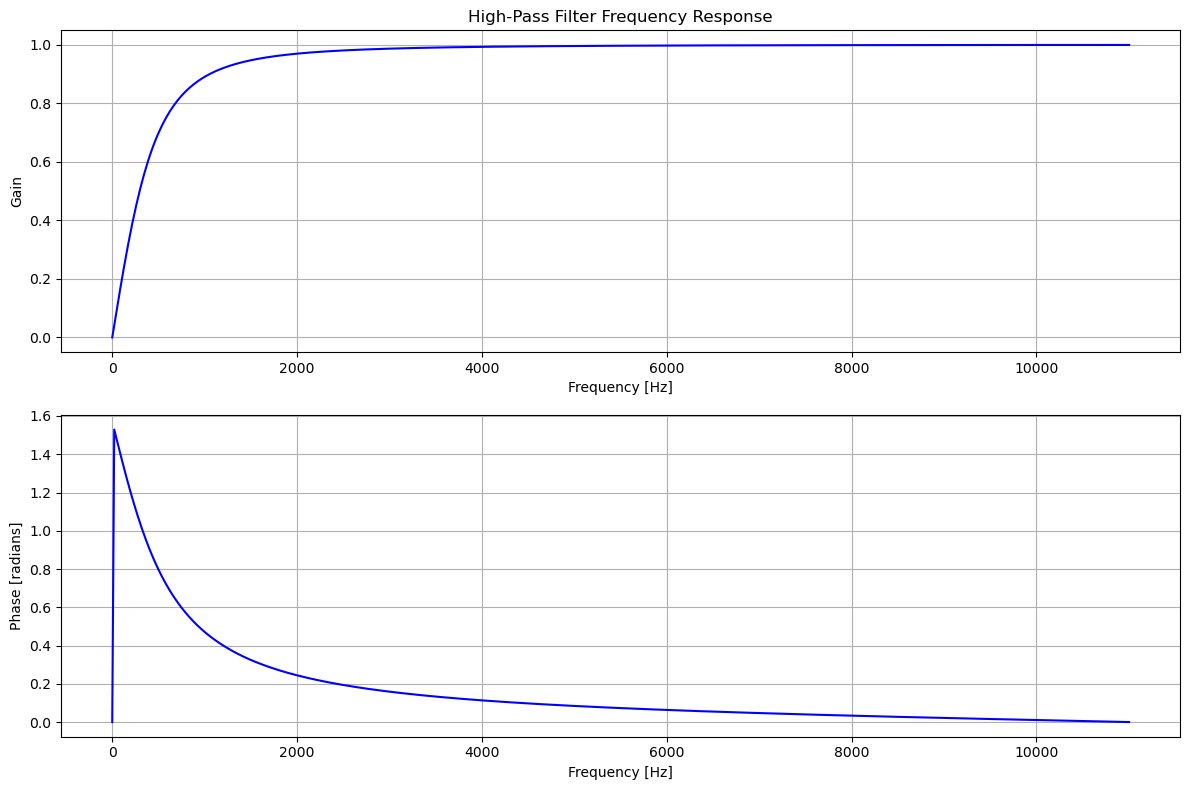

In [7]:
produce_spectrogram(y_ft_denoised, sr_ft, 512, method='stft')
filter_response_plots(y_ft_denoised, sr_ft, 512)

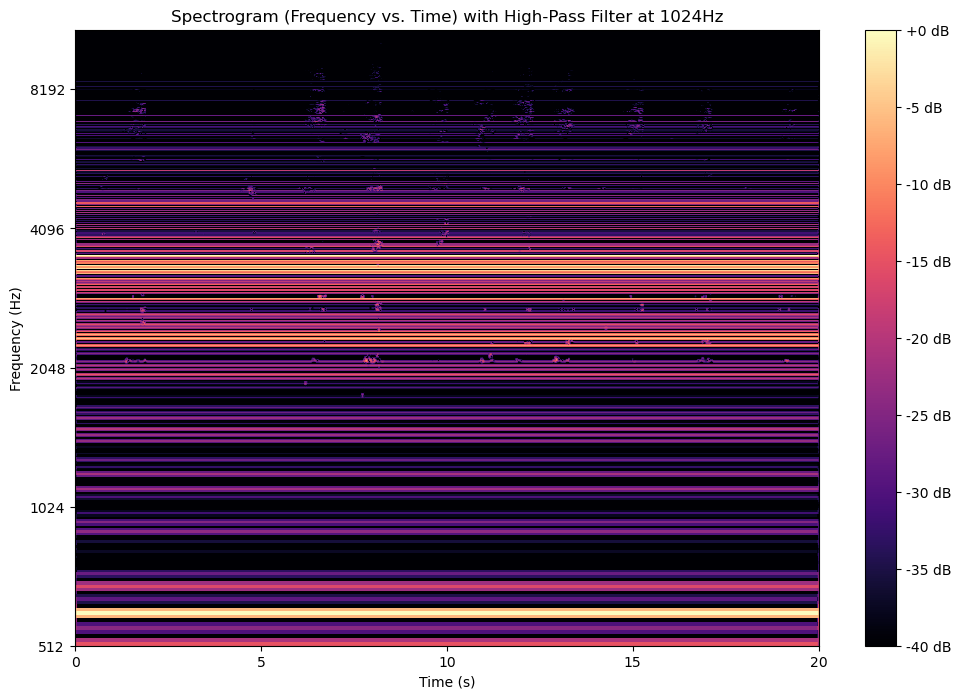

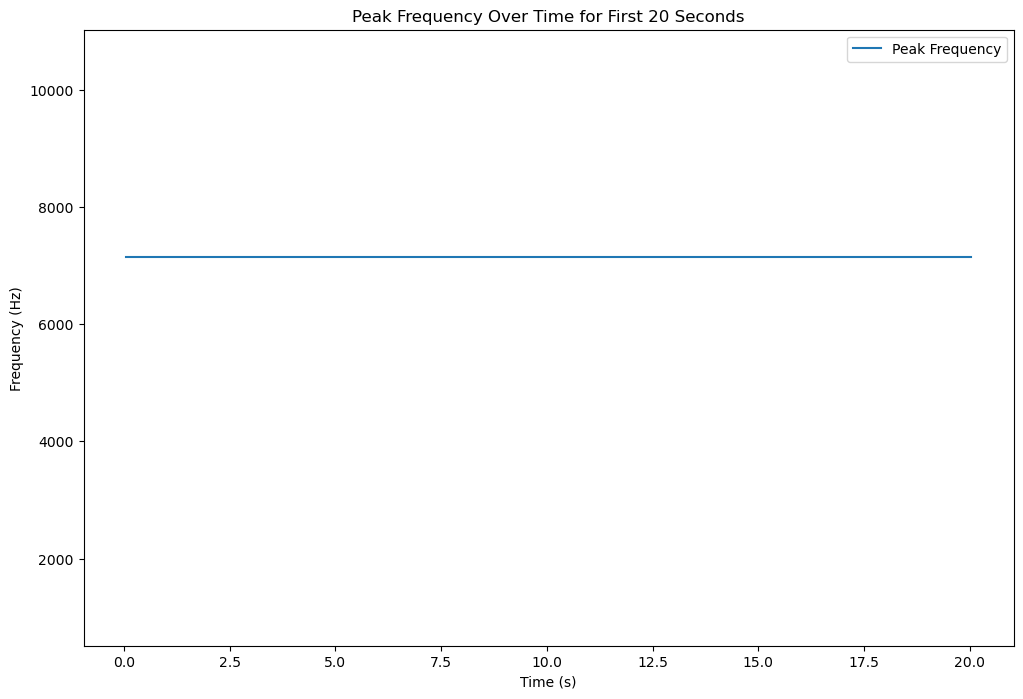

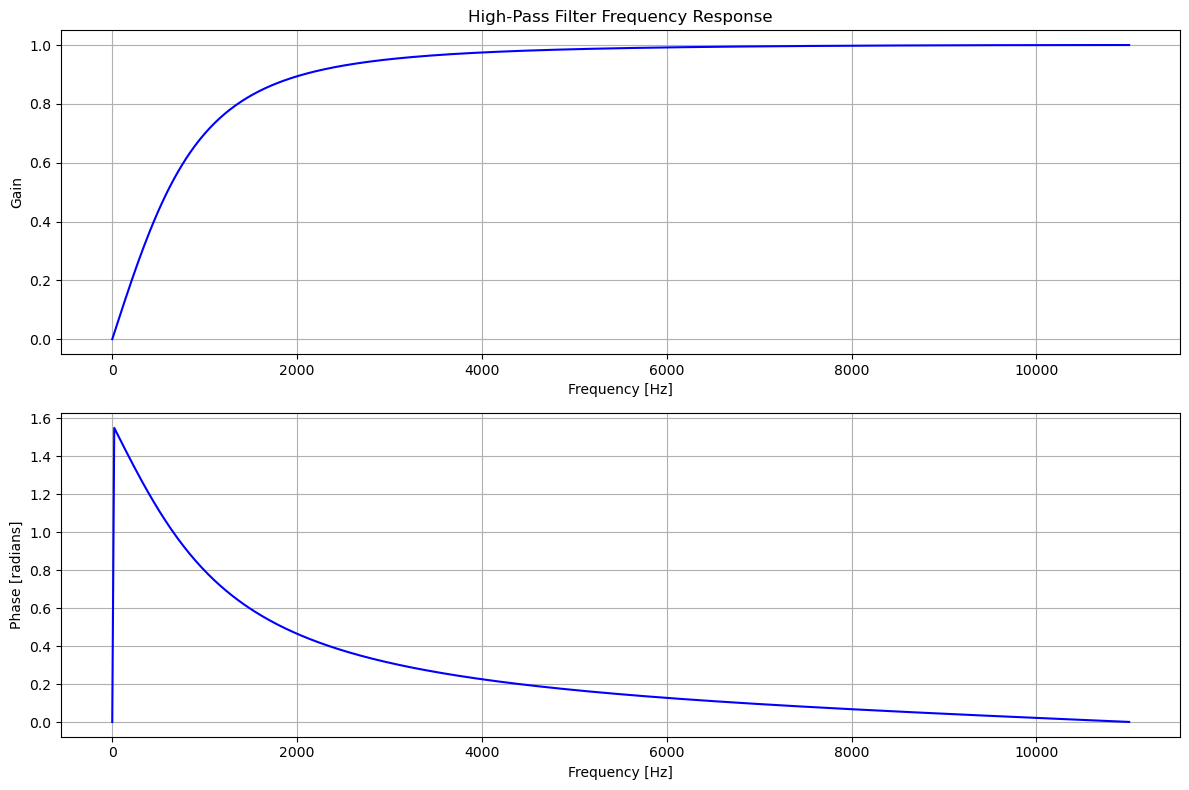

In [8]:
produce_spectrogram(y_ft_denoised, sr_ft, 1024, method='stft')
filter_response_plots(y_ft_denoised, sr_ft, 1024)

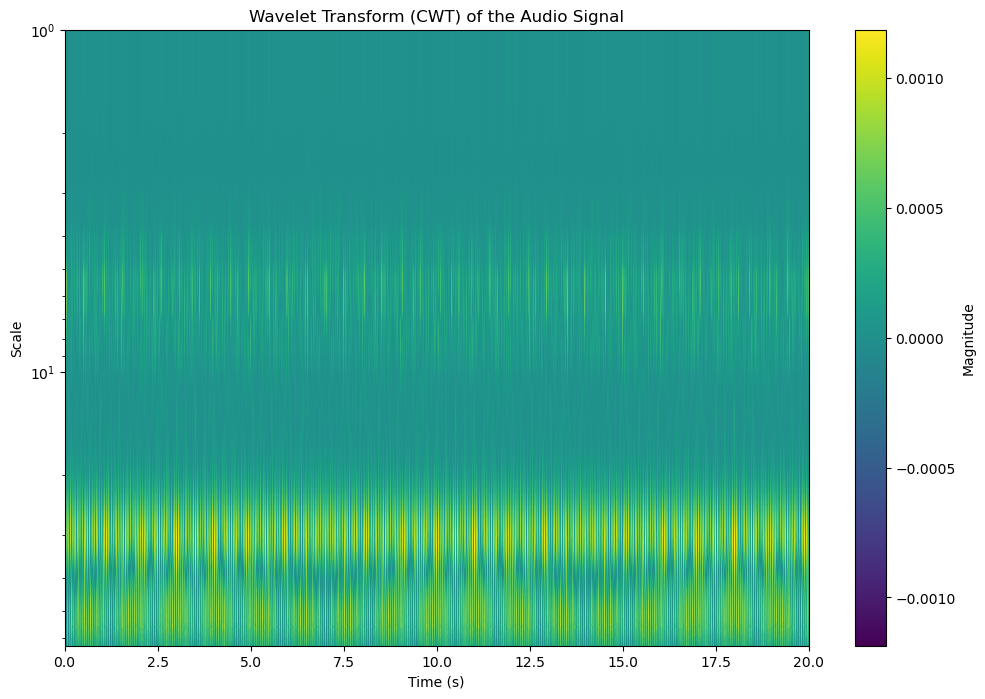

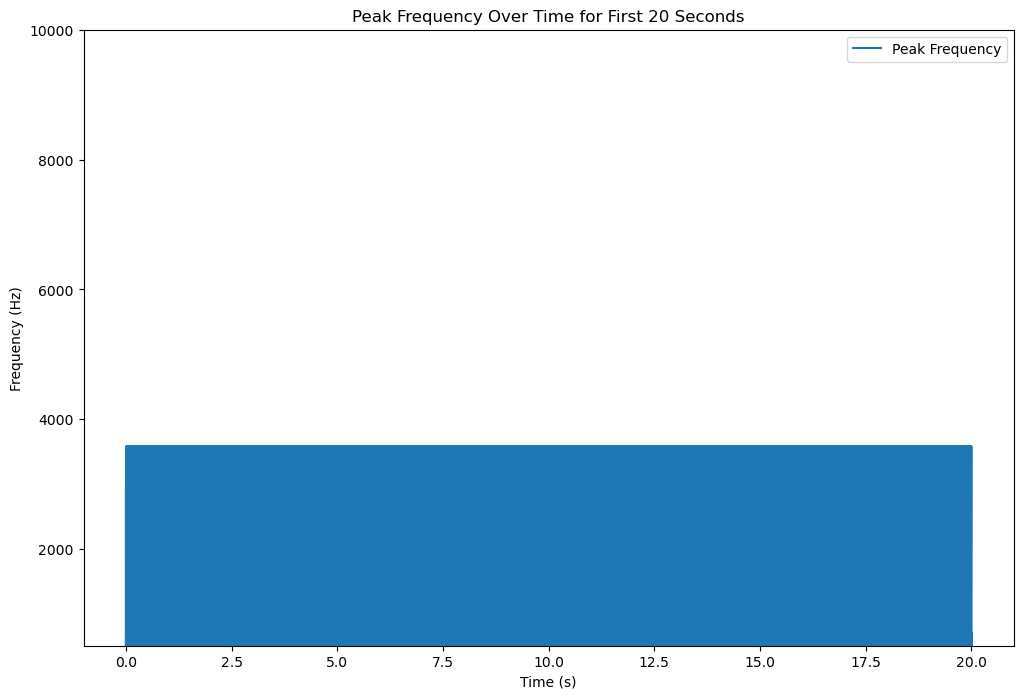

In [9]:
produce_spectrogram(y_ft_denoised, sr_ft, 512, method='wavelet')